In [66]:
# import pandas_datareader.data as web
# df = web.DataReader('MSFT', 'yahoo', start='2010-01-01', end='2020-12-31')

In [73]:
# df['Adj Close'].to_frame().rename(columns={'Adj Close':'close'}).to_csv('../../datasets/Ch9/msft.csv')

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pathlib import Path
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tools.eval_measures import rmspe, rmse, aic, bic
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import numpy as np

plt.style.use('default')
plt.rcParams["figure.figsize"] = [10, 4]
from pandas.plotting import register_matplotlib_converters
# plt.rc("figure", figsize=(16, 12))
# plt.rc("font", size=13)

In [74]:
msft_file = Path('../../datasets/Ch9/msft.csv')
msft = pd.read_csv(msft_file, index_col='Date', 
                   parse_dates=True)

In [33]:
life_file = Path('../../datasets/Ch9/life_expectancy_birth.csv')
life = pd.read_csv(life_file, 
                   index_col='year',
                   parse_dates=True).dropna()

In [34]:
milk_file = Path('../../datasets/Ch9/milk_production.csv')
milk = pd.read_csv(milk_file, 
                   index_col='month', 
                   parse_dates=True)

In [98]:
print(f'''
milk {milk.shape[0]} records
life {life.shape[0]} records
msft {msft.shape[0]} records
''')


milk 168 records
life 60 records
msft 2769 records



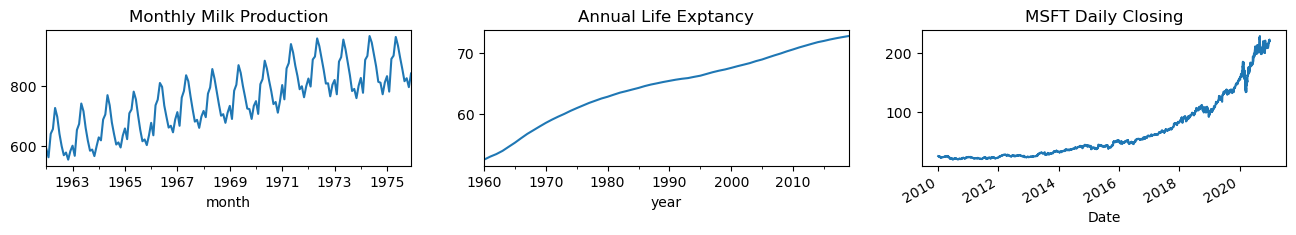

<Figure size 1400x300 with 0 Axes>

In [75]:
fig, axs = plt.subplots(1, 3)
plt.figure(figsize=(14, 3))

milk.plot(ax=axs[0], figsize=(16, 2), 
          title='Monthly Milk Production', legend=False)
life.plot(ax=axs[1], 
          title='Annual Life Exptancy', legend=False)
msft.plot(ax=axs[2], 
          title='MSFT Daily Closing', legend=False)
plt.show()

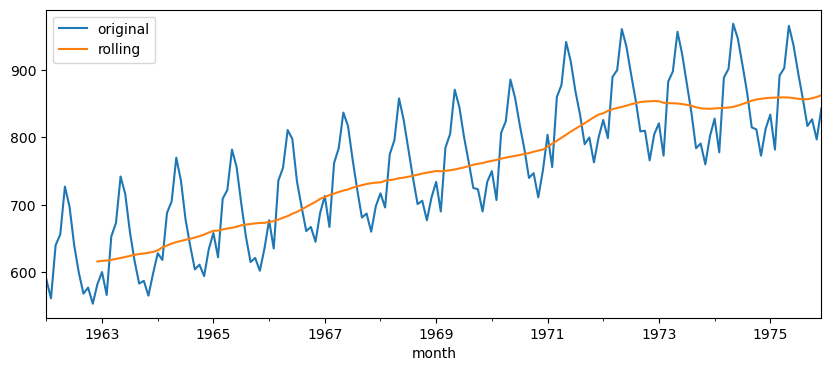

In [76]:
ax = milk.plot()
milk.rolling(12).mean().plot(ax=ax)
plt.legend(['original','rolling'])

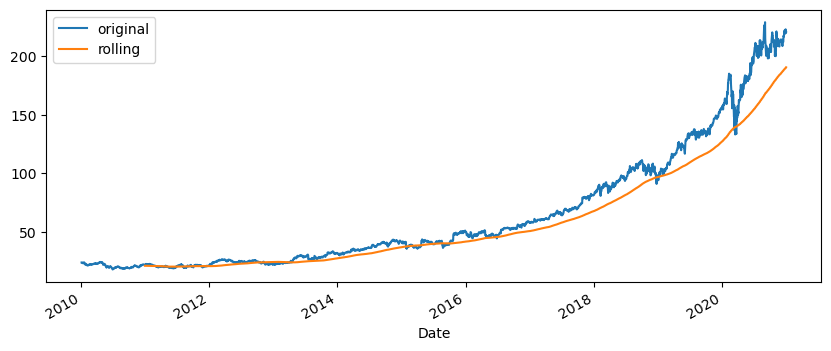

In [81]:
ax = msft.plot()
msft.rolling(252).mean().plot(ax=ax)
plt.legend(['original','rolling'])

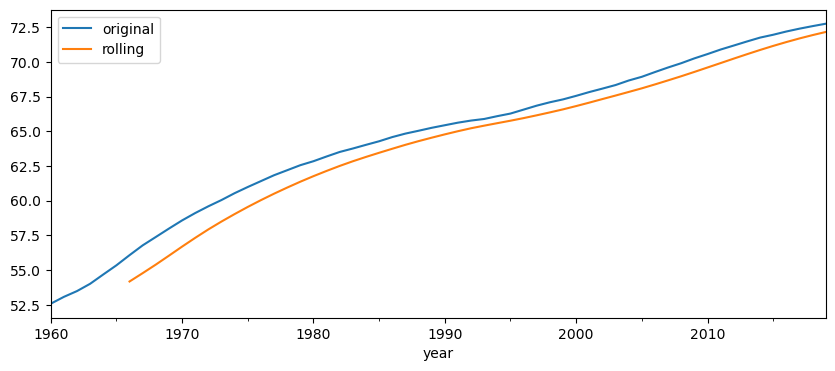

In [87]:
ax = life.plot()
life.rolling(7).mean().plot(ax=ax)
plt.legend(['original','rolling'])

In [92]:
milk_stl = STL(milk, period=12).fit()
life_stl = STL(life, period=7).fit() #seasonal_decompose(life)
msft_stl = STL(msft, period=252).fit()

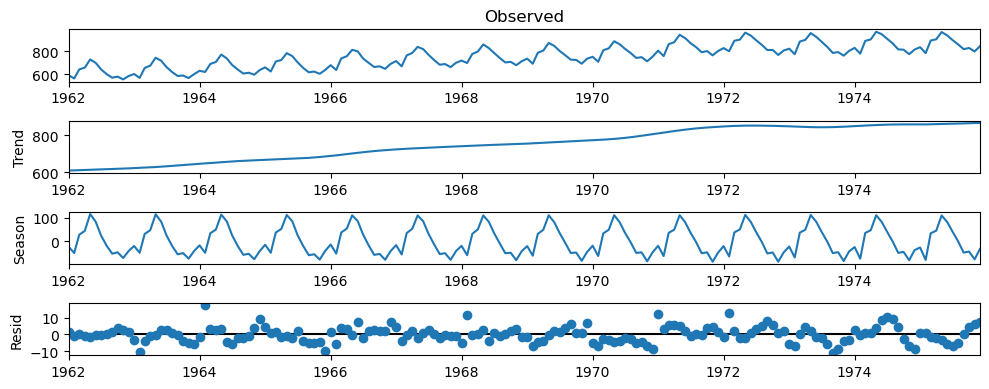

In [93]:
#milk_stl = seasonal_decompose(milk, model='addiditive', period=12)
milk_stl.plot()
plt.show()

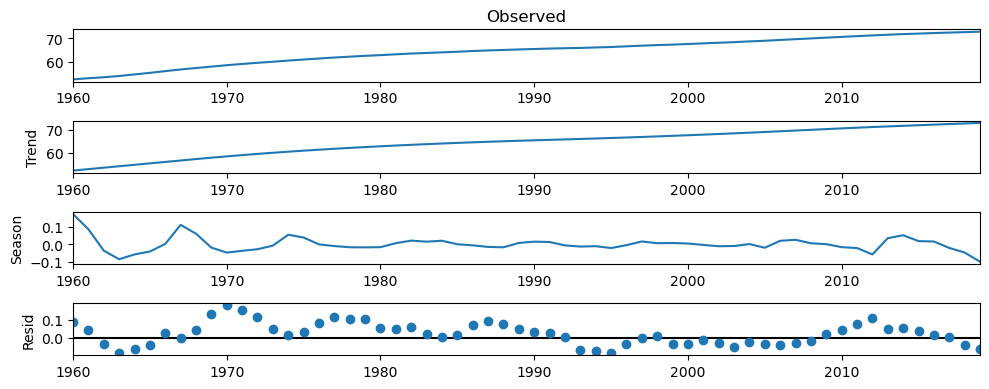

In [94]:
life_stl.plot()
plt.show()

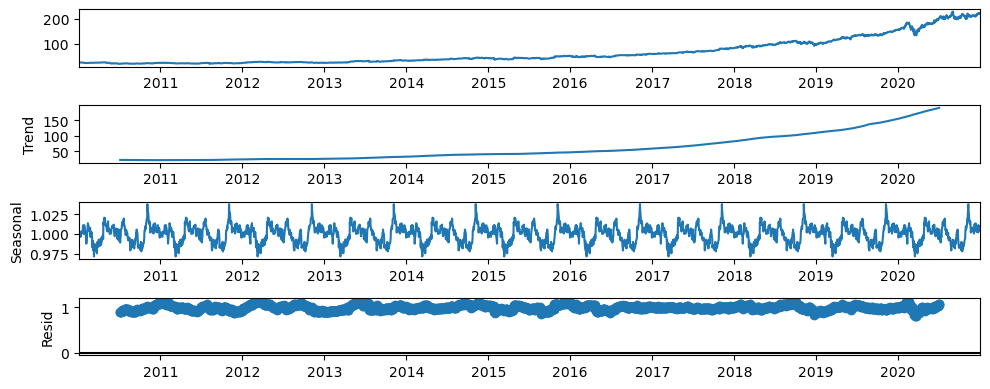

In [96]:
#msft_stl = seasonal_decompose(msft, model='multiplicative', period=252)
msft_stl.plot()
plt.show()

In [59]:
def check_stationarity(df):
    results = adfuller(df)[1]
    if results < 0.05:
        print("Stationary ", results)
    else:
        print("Not Stationary ", results)

In [60]:
check_stationarity(milk)
check_stationarity(life)
check_stationarity(msft)

Not Stationary  0.6274267086030337
Not Stationary  0.4660562989594237
Not Stationary  0.9771995408059895


**Detrending**
1. Removing Trend

In [61]:
tl = pd.DataFrame(life.values.ravel() - life_stl.trend, index=life.index).dropna()
tm = pd.DataFrame(msft.values.ravel() - msft_stl.trend.values, index=msft.index).dropna()
tk = pd.DataFrame(milk.values.ravel() - milk_stl.trend.values, index=milk.index).dropna()

In [62]:
check_stationarity(tl)
check_stationarity(tm)
check_stationarity(tk)

Not Stationary  nan
Stationary  2.138115788796465e-14
Stationary  0.00030299751224302415


2. Differencing

In [63]:
check_stationarity(milk.diff().dropna())
check_stationarity(life.diff().dropna())
check_stationarity(msft.diff().dropna())

Stationary  0.030068004001782334
Not Stationary  0.7874973513473611
Stationary  1.3548449666079182e-08


Detrend using statsmodels detrend function (using polynomial)

In [55]:
from statsmodels.tsa.tsatools import detrend

In [99]:
print(f'''
milk {milk.shape[0]} records
life {life.shape[0]} records
msft {msft.shape[0]} records
''')


milk 168 records
life 60 records
msft 2769 records



In [107]:
168 - round(168*0.2)

134

In [118]:
def split_data(df, test_split):
    l = df.shape[0]
    t_idx = l - round(l*test_split)
    train = df.iloc[ : t_idx]
    test = df.iloc[t_idx : ]

    print(f'train: {train.shape[0]} , test: {test.shape[0]}')
    return train, test

In [122]:
test_split = 0.20
milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)
msft_train, msft_test = split_data(msft, test_split)

train: 134 , test: 34
train: 48 , test: 12
train: 2215 , test: 554


In [124]:
milk_exp = ExponentialSmoothing(milk_train, 
                           initialization_method='estimated', trend='add',
                                seasonal='add',
                                damped_trend=True).fit(optimized= True, use_brute = True)

In [127]:
milk_exp.summary()

Dep. Variable:,production,No. Observations:,134
Model:,ExponentialSmoothing,SSE,6390.725
Optimized:,True,AIC,551.878
Trend:,Additive,BIC,601.142
Seasonal:,Additive,AICC,558.545
Seasonal Periods:,12,Date:,"Tue, 14 Dec 2021"
Box-Cox:,False,Time:,00:05:45
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7399520,alpha,True
smoothing_trend,2.0208e-09,beta,True


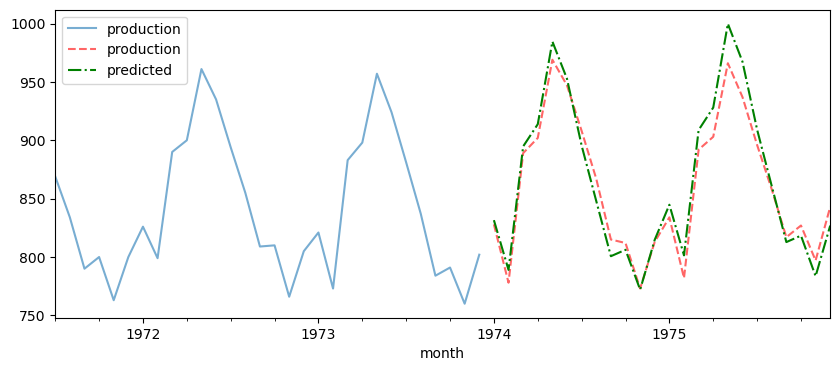

In [218]:
ax = m_train[-30:].plot(label='train', alpha=0.6)
m_test.plot(color='r',label='test', alpha=0.6, style='--', ax=ax)
milk_exp.forecast(24).plot(ax=ax, color='g', style='-.', label='predicted')
plt.legend()
plt.show()

In [26]:
life_exp = ExponentialSmoothing(life, 
                           initialization_method='estimated', trend='add',
                                damped_trend=True).fit(optimized= True, use_brute = True)

/Users/tarekatwan/opt/anaconda3/envs/ch2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


In [ ]:
life_e

<AxesSubplot:xlabel='year'>

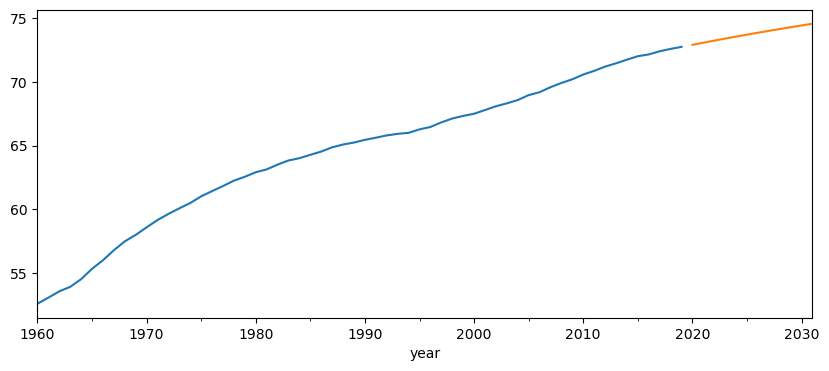

In [205]:
life_exp.fittedvalues.plot()
life_exp.forecast(12).plot()

In [ ]:
milk_exp = ExponentialSmoothing(m_train, 
                           initialization_method='estimated', trend='add',
                                seasonal='mul',
                                damped_trend=True).fit(optimized= True, use_brute = True)